## Assignment 10: Fine-Tuning PLM for Monetary Policy Stance Classification
----
Name: Shiqi Hu

GTID: 904061372

### Step 0: Background Research
---

**Define Hawkish and Dovish**

- **Hawkish**: In monetary policy, it refers to a stance where the Federal Reserve favors raising interest rates and reducing the money supply. This approach often includes quantitative tightening (selling Treasury securities to tighten liquidity), aiming to curb inflation, but it can also slow economic growth.

- **Dovish**: In contrast, dovish refers to a stance where the Federal Reserve favors lower interest rates and an increase in money supply. The Fed may pursue quantitative easing by buying Treasuries, which stimulates economic growth but can lead to higher inflation if sustained.

**Key Monetary Policy Events**

- **Dot-com Bubble Burst (2000-2001)**: Following rapid economic growth and market speculation, the Fed raised interest rates multiple times in the late 1990s. When the bubble burst in 2000, to stimulate the economy, the Fed quickly cut rates from 6.51% in Nov 2000 to 1.82% in Dec 2001, a shift that marked a significant response to tech sector volatility.

- **2008 Financial Crisis**: In response to the collapse of major financial institutions, the Fed slashed interest rates from 5.26% in July 2007 to near zero in Dec 2008 and introduced unprecedented quantitative easing (QE) measures, purchasing large amounts of Treasuries and mortgage-backed securities to support financial stability and revive the economy.

- **2015-2018 Rate Hikes**: After years of near-zero interest rates post-2008, the Fed gradually raised rates starting in 2015, reflecting a more hawkish stance as the economy recovered. This marked a shift toward normalization of monetary policy following the crisis-era support.

- **COVID-19 Pandemic (2020)**: Facing a severe economic downturn, the Fed once again cut interest rates to near zero and launched aggressive QE, buying massive amounts of Treasuries and other securities. This dovish approach was aimed at supporting liquidity and economic recovery amid widespread disruptions.

- **2022-2023 Inflation Surge and Rate Hikes**: In response to historic inflation, the Fed rapidly increased interest rates starting from near zero in March 2022 to around 5.33% in Aug 2023, implementing the most aggressive rate hikes in decades. This hawkish policy was designed to curb inflation but raised concerns about potential recessionary impacts.

In [11]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install --upgrade transformers
!pip install datasets==2.21.0
# easier for users to scale their models from single-device to multi-device environments without needing to manually configure complex setups.
!pip install --upgrade accelerate
!pip install --upgrade torch
!pip install openpyxl
!pip install pandas_datareader

Looking in indexes: https://download.pytorch.org/whl/cu118


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import io
import re
import os
import pandas_datareader as pdr
from datetime import datetime

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
# from transformers import pipeline
from transformers import AutoConfig
from transformers import DataCollatorWithPadding
from datasets import Dataset as HFDataset
import torch
# from torch.utils.data import Dataset

### Step 1: Fine-Tuning RoBERTa
---
**Q: Why tokenization is important for models like RoBERTa?**

- Tokenization is essential for models like RoBERTa because it breaks down text into smaller pieces ("tokens") that the model can understand and process. 
- Specifically, RoBERTa uses a specific tokenizer to convert words into numerical representations, which the model requires for learning patterns in the text. 
- Setting padding='max_length' ensures that all inputs have the same length by adding padding where necessary, while truncation=True cuts off longer texts to a maximum length of 256 tokens. This standardization helps RoBERTa process batches of text efficiently and avoids errors from variable-length inputs.

**Q: What does the confusion matrix tell you about the model’s performance on hawkish, dovish, and neutral labels?**
- After conducting hyperparameter tuning with the training and validation sets (where 10% of the full training data was used for validation), the model achieved an F1-score of 0.70 on the test set. This indicates that the model's classification performance is fairly balanced across labels.

- The confusion matrix shows the following insights about the model's performance:
    - **Dovish Labels**: The model correctly classified 49 out of 69 "Dovish" instances, with a few misclassifications primarily into the "Neutral" category (16 instances), indicating some confusion between dovish and neutral tones.
    - **Hawkish Labels**: The model performs best on "Hawkish" instances, correctly classifying 41 out of 49, with minimal confusion. This suggests that the model has a stronger ability to identify hawkish language.
    - **Neutral Labels**: The model correctly identified 58 out of 96 "Neutral" cases but misclassified 21 as "Dovish" and 17 as "Hawkish." This pattern indicates that neutral language can be challenging to distinguish, especially from dovish tones.

**Q: How does performance change as you vary learning rate, batch size, and number of epochs?**

**My parameters include:**
- learning_rates = [2e-5, 5e-5, 1e-4]  
- batch_sizes = [4, 8, 16]           
- num_epochs = [3, 5, 10]   

**Performance analysis on the validation set based on hyperparameters (F1-score):**
- Impact of Learning Rate on F1 Score:
  - **Learning Rate = 2.00e-05**: Generally performs well with batch sizes 4, 8, and 16, especially as the number of epochs increases. F1 scores range from around 0.538 to 0.678, with higher epochs and larger batch sizes (e.g., batch size 16, epochs 5 or 10) showing improvements in performance.
  - **Learning Rate = 5.00e-05**: Shows the best overall F1 scores, especially with batch sizes of 8 and 16 and higher epochs. The highest F1 scores (around 0.723 and 0.720) are achieved with a batch size of 16 and epochs of 5 and 10, respectively. This learning rate provides a good balance between stability and performance, as it consistently outperforms the others.
  - **Learning Rate = 1.00e-04**: F1 scores remain very low (around 0.192) across all configurations of batch size and epochs, suggesting this learning rate is too high and may lead to unstable or underperforming models.

- Impact of Batch Size on F1 Score:
  - **Batch Size = 4**: With lower batch sizes, the model performance is less consistent. For learning rates of 2.00e-05 and 5.00e-05, F1 scores are generally lower compared to larger batch sizes, even when the number of epochs increases. The highest F1 score for this batch size is around 0.678 with a learning rate of 2.00e-05 and 10 epochs, indicating that increasing epochs helps compensate for the smaller batch size.
  - **Batch Size = 8**: Batch size 8 provides better performance stability than batch size 4, particularly with learning rates of 2.00e-05 and 5.00e-05. The F1 score reaches around 0.646 and 0.602 with 5 and 10 epochs respectively for 2.00e-05, and around 0.670 with 5.00e-05 and 10 epochs, indicating improved performance with higher epochs.
  - **Batch Size = 16**: The best-performing models are found with batch size 16, especially with a learning rate of 5.00e-05. The highest F1 scores of 0.723 and 0.720 are achieved with epochs of 5 and 10 for the 5.00e-05 learning rate, indicating that larger batch sizes are beneficial for this setup. However, with a learning rate of 1.00e-04, performance remains poor across all epochs, suggesting that an optimal learning rate is necessary to benefit from larger batch sizes.

- Number of Epochs:
  - **3 Epochs**: Models with fewer epochs tend to underperform, especially with higher batch sizes. The F1 score for 3 epochs maxes out at around 0.670 for batch size 16 and a learning rate of 5.00e-05, indicating that higher epochs are generally more effective for this problem.
  - **5 Epochs**: Increasing the number of epochs to 5 typically improves performance, especially with a batch size of 16 and a learning rate of 5.00e-05, achieving the highest F1 score of 0.723. For lower learning rates and smaller batch sizes, the improvements are moderate but noticeable.
  - **10 Epochs**: Further increasing epochs to 10 shows mixed results, with some combinations (e.g., 5.00e-05, batch size 16) maintaining high F1 scores around 0.720. However, additional epochs seem to provide diminishing returns, especially for smaller batch sizes and suboptimal learning rates.

**Summary of Findings**
- Optimal Combination: A learning rate of 5.00e-05, batch size of 16, and 5 epochs yield the best F1 scores (around 0.723).
- Learning Rate Sensitivity: The model is highly sensitive to the learning rate, with 2.00e-05 and 5.00e-05 performing well, while 1.00e-04 results in consistently low F1 scores.
- Batch Size and Epoch Balance: Larger batch sizes (16) combined with moderate epochs (5 to 10) provide the best performance, while smaller batch sizes benefit from higher epochs.


In [13]:
# load model and tokenizer：
model_name = "roberta-base"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)    # 3 labels: Dovish, Hawkish, Neutral
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# prepare data for model

train_df_full = pd.read_excel('lab-manual-mm-train-5768.xlsx')  
train_df, val_df = train_test_split(train_df_full, test_size=0.1) 
test_df = pd.read_excel('lab-manual-mm-test-5768.xlsx') 

train_df['label'] = train_df['label'].astype(int)
val_df['label'] = val_df['label'].astype(int)
test_df['label'] = test_df['label'].astype(int)

# convert pandas df to datasets object
train_dataset = HFDataset.from_pandas(train_df)
val_dataset = HFDataset.from_pandas(val_df)
test_dataset = HFDataset.from_pandas(test_df)

# Define data preprocessing functions
def tokenize_function(examples):
    return tokenizer(examples['sentence'], 
                     padding='max_length', 
                     truncation=True, 
                     max_length=256)

# tokenize each sentence in training, validation & test set
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename 'label' column to 'labels'
tokenized_train_dataset = tokenized_train_dataset.rename_column("label", "labels")
tokenized_val_dataset = tokenized_val_dataset.rename_column("label", "labels")
tokenized_test_dataset = tokenized_test_dataset.rename_column("label", "labels")

# Set the format for PyTorch compatibility, only keeping necessary columns
tokenized_train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Set up the data collator for dynamic padding (we may have some excess padding)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/770 [00:00<?, ? examples/s]

Map:   0%|          | 0/86 [00:00<?, ? examples/s]

Map:   0%|          | 0/214 [00:00<?, ? examples/s]

In [15]:
# print(tokenized_train_dataset.column_names)
# print(tokenized_val_dataset.column_names)


In [16]:
# # Check the length of the dataset
# print("Length of tokenized_train_dataset:", len(tokenized_train_dataset))
# print("Length of tokenized_val_dataset:", len(tokenized_val_dataset))

# # # Try accessing the first few elements to verify structure
# # print(tokenized_train_dataset[0])  # Should work if dataset is properly indexed
# # print(tokenized_val_dataset[1])

In [17]:
# If no enough space and you want to rerun the training, use the following code to delete the checkpoints
# import os
# import shutil

# # Hyperparameters combinations
# learning_rates = [2e-5, 5e-5, 1e-4]  
# batch_sizes = [4, 8, 16]           
# num_epochs = [3, 5, 10]              

# base_dir = '/home/app/hsq/results_lr{lr}_bs{batch_size}_epochs{epoch}'

# # delete all specified checkpoints
# for lr in learning_rates:
#     for batch_size in batch_sizes:
#         for epoch in num_epochs:
#             output_dir = base_dir.format(lr=lr, batch_size=batch_size, epoch=epoch)

#             # check if directory exists
#             if os.path.exists(output_dir):
#                 print(f"Deleting directory: {output_dir}")
#                 shutil.rmtree(output_dir)
#             else:
#                 print(f"Directory not found: {output_dir}")

# print("All specified checkpoints have been deleted.")

In [18]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch is using the GPU.")
    print("Device:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. PyTorch is using the CPU.")

CUDA is available. PyTorch is using the GPU.
Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [23]:
# Hyperparameter tuning

learning_rates = [2e-5, 5e-5, 1e-4] 
batch_sizes = [4, 8, 16]            
num_epochs = [3, 5, 10] 

# Initialize a list to save results
results = []

# Loop through different combinations of hyperparameters
for lr in learning_rates:
    for batch_size in batch_sizes:
        for epoch in num_epochs:
            
            # Define output directory for current hyperparameter combination
            output_dir = f'./hsq/results_lr{lr}_bs{batch_size}_epochs{epoch}'

            # Define training arguments
            training_args = TrainingArguments(
                output_dir=output_dir,                                      # Directory to save results
                learning_rate=lr,                                           # Set learning rate
                per_device_train_batch_size=batch_size,                     # Train batch size per device
                per_device_eval_batch_size=batch_size,                      # Eval batch size per device
                num_train_epochs=epoch,                                     # Number of epochs
                push_to_hub=False,
                fp16=True,                                                  # Use mixed precision training
                report_to="none",                                           # Disable logging to external tools
                save_strategy="epoch",                                      # Save the model at the end of each epoch
                evaluation_strategy="epoch",                                # Evaluate the model at the end of each epoch
                metric_for_best_model="eval_loss",                          # Use evaluation loss to determine the best model
                greater_is_better=False,                                    # Lower evaluation loss is better
                save_total_limit=3,                                         # Keep only the best model checkpoint
                load_best_model_at_end=True                                 # Load the best model at the end of training
            )

            # Use the Trainer class to fine-tune the model
            trainer = Trainer(
                model=model,                                        # The pre-trained model
                args=training_args,                                 # Training arguments
                train_dataset=tokenized_train_dataset,              # Training dataset
                eval_dataset=tokenized_val_dataset,                 # Validation dataset (instead of test set)
                tokenizer=tokenizer,
                data_collator=data_collator
            )

            # Check if there is an existing checkpoint
            resume_checkpoint = None
            if os.path.isdir(output_dir) and len(os.listdir(output_dir)) > 0:
                resume_checkpoint = output_dir  # Resume from the latest checkpoint in the directory
            

            # Start training
            print(f"Training with lr={lr}, batch_size={batch_size}, epochs={epoch}")
            if resume_checkpoint and os.path.exists(os.path.join(resume_checkpoint, "trainer_state.json")):
                trainer.train(resume_from_checkpoint=resume_checkpoint)
            else:
                print("Checkpoint missing or incomplete, starting training from scratch.")
                trainer.train()

            # Save the model after training
            trainer.save_model(output_dir=output_dir)

            # Get predictions on the validation set
            predictions, labels, _ = trainer.predict(tokenized_val_dataset)
            predictions = np.argmax(predictions, axis=1)

            # Print classification report including F1 score
            report = classification_report(labels, predictions, target_names=['Dovish', 'Hawkish', 'Neutral'], output_dict=True)
            f1_score = report['macro avg']['f1-score']
            print(f"F1 Score: {f1_score:.4f}")

            # Save the results, including hyperparameters and F1 score
            results.append({
                'learning_rate': lr,
                'batch_size': batch_size,
                'epochs': epoch,
                'f1_score': report['macro avg']['f1-score'],  # Use macro average F1 score
                'accuracy': report['accuracy'],               # Save accuracy
                'model_path': output_dir
            })


Training with lr=2e-05, batch_size=4, epochs=3
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/579 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 1.2489852905273438, 'eval_runtime': 0.7002, 'eval_samples_per_second': 122.831, 'eval_steps_per_second': 31.422, 'epoch': 1.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 1.335513949394226, 'eval_runtime': 1.0189, 'eval_samples_per_second': 84.403, 'eval_steps_per_second': 21.591, 'epoch': 2.0}
{'loss': 0.6337, 'grad_norm': 132.41455078125, 'learning_rate': 2.867012089810017e-06, 'epoch': 2.59}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 1.842817783355713, 'eval_runtime': 0.8945, 'eval_samples_per_second': 96.147, 'eval_steps_per_second': 24.596, 'epoch': 3.0}
{'train_runtime': 119.1246, 'train_samples_per_second': 19.391, 'train_steps_per_second': 4.86, 'train_loss': 0.6161545801245075, 'epoch': 3.0}


  0%|          | 0/22 [00:00<?, ?it/s]

F1 Score: 0.3590
Training with lr=2e-05, batch_size=4, epochs=5
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/965 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.0485849380493164, 'eval_runtime': 1.0904, 'eval_samples_per_second': 78.87, 'eval_steps_per_second': 20.176, 'epoch': 1.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 1.6384098529815674, 'eval_runtime': 0.837, 'eval_samples_per_second': 102.744, 'eval_steps_per_second': 26.283, 'epoch': 2.0}
{'loss': 0.5038, 'grad_norm': 0.06677847355604172, 'learning_rate': 9.761658031088083e-06, 'epoch': 2.59}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.131734848022461, 'eval_runtime': 0.8335, 'eval_samples_per_second': 103.176, 'eval_steps_per_second': 26.394, 'epoch': 3.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.117330312728882, 'eval_runtime': 2.8098, 'eval_samples_per_second': 30.607, 'eval_steps_per_second': 7.83, 'epoch': 4.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.177220106124878, 'eval_runtime': 0.7272, 'eval_samples_per_second': 118.261, 'eval_steps_per_second': 30.253, 'epoch': 5.0}
{'train_runtime': 208.9682, 'train_samples_per_second': 18.424, 'train_steps_per_second': 4.618, 'train_loss': 0.37891921601764894, 'epoch': 5.0}


  0%|          | 0/22 [00:00<?, ?it/s]

F1 Score: 0.6708
Training with lr=2e-05, batch_size=4, epochs=10
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/1930 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 3.526252508163452, 'eval_runtime': 0.8608, 'eval_samples_per_second': 99.905, 'eval_steps_per_second': 25.557, 'epoch': 1.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 3.1557552814483643, 'eval_runtime': 0.9726, 'eval_samples_per_second': 88.427, 'eval_steps_per_second': 22.621, 'epoch': 2.0}
{'loss': 0.3637, 'grad_norm': 0.13887369632720947, 'learning_rate': 1.4891191709844561e-05, 'epoch': 2.59}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.005854368209839, 'eval_runtime': 0.8847, 'eval_samples_per_second': 97.208, 'eval_steps_per_second': 24.867, 'epoch': 3.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.4389235973358154, 'eval_runtime': 1.1063, 'eval_samples_per_second': 77.735, 'eval_steps_per_second': 19.886, 'epoch': 4.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.0476882457733154, 'eval_runtime': 1.0457, 'eval_samples_per_second': 82.245, 'eval_steps_per_second': 21.039, 'epoch': 5.0}
{'loss': 0.2351, 'grad_norm': 0.008012010715901852, 'learning_rate': 9.709844559585493e-06, 'epoch': 5.18}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.775815963745117, 'eval_runtime': 0.8383, 'eval_samples_per_second': 102.586, 'eval_steps_per_second': 26.243, 'epoch': 6.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.584737539291382, 'eval_runtime': 0.8517, 'eval_samples_per_second': 100.978, 'eval_steps_per_second': 25.832, 'epoch': 7.0}
{'loss': 0.0701, 'grad_norm': 0.0038950066082179546, 'learning_rate': 4.528497409326425e-06, 'epoch': 7.77}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.7857296466827393, 'eval_runtime': 0.8125, 'eval_samples_per_second': 105.845, 'eval_steps_per_second': 27.077, 'epoch': 8.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.8408586978912354, 'eval_runtime': 0.8786, 'eval_samples_per_second': 97.88, 'eval_steps_per_second': 25.039, 'epoch': 9.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.821669101715088, 'eval_runtime': 0.9166, 'eval_samples_per_second': 93.823, 'eval_steps_per_second': 24.001, 'epoch': 10.0}
{'train_runtime': 400.691, 'train_samples_per_second': 19.217, 'train_steps_per_second': 4.817, 'train_loss': 0.1768448313283179, 'epoch': 10.0}


  0%|          | 0/22 [00:00<?, ?it/s]

F1 Score: 0.6790
Training with lr=2e-05, batch_size=8, epochs=3
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.391613245010376, 'eval_runtime': 0.903, 'eval_samples_per_second': 95.238, 'eval_steps_per_second': 12.182, 'epoch': 1.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.4315099716186523, 'eval_runtime': 0.6937, 'eval_samples_per_second': 123.981, 'eval_steps_per_second': 15.858, 'epoch': 2.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.4436864852905273, 'eval_runtime': 0.7435, 'eval_samples_per_second': 115.666, 'eval_steps_per_second': 14.795, 'epoch': 3.0}
{'train_runtime': 90.7385, 'train_samples_per_second': 25.458, 'train_steps_per_second': 3.207, 'train_loss': 0.19783202233593078, 'epoch': 3.0}


  0%|          | 0/11 [00:00<?, ?it/s]

F1 Score: 0.5838
Training with lr=2e-05, batch_size=8, epochs=5
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.3645031452178955, 'eval_runtime': 0.7339, 'eval_samples_per_second': 117.178, 'eval_steps_per_second': 14.988, 'epoch': 1.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.5351402759552, 'eval_runtime': 0.7324, 'eval_samples_per_second': 117.429, 'eval_steps_per_second': 15.02, 'epoch': 2.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.5119197368621826, 'eval_runtime': 0.6656, 'eval_samples_per_second': 129.211, 'eval_steps_per_second': 16.527, 'epoch': 3.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.7310681343078613, 'eval_runtime': 0.721, 'eval_samples_per_second': 119.275, 'eval_steps_per_second': 15.256, 'epoch': 4.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.739090919494629, 'eval_runtime': 0.763, 'eval_samples_per_second': 112.716, 'eval_steps_per_second': 14.417, 'epoch': 5.0}
{'train_runtime': 148.1981, 'train_samples_per_second': 25.979, 'train_steps_per_second': 3.273, 'train_loss': 0.10418391276880638, 'epoch': 5.0}


  0%|          | 0/11 [00:00<?, ?it/s]

F1 Score: 0.6466
Training with lr=2e-05, batch_size=8, epochs=10
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/970 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.8795413970947266, 'eval_runtime': 0.7029, 'eval_samples_per_second': 122.345, 'eval_steps_per_second': 15.649, 'epoch': 1.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.4858617782592773, 'eval_runtime': 0.7211, 'eval_samples_per_second': 119.266, 'eval_steps_per_second': 15.255, 'epoch': 2.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.7025318145751953, 'eval_runtime': 0.7722, 'eval_samples_per_second': 111.366, 'eval_steps_per_second': 14.245, 'epoch': 3.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 3.13247013092041, 'eval_runtime': 0.7826, 'eval_samples_per_second': 109.892, 'eval_steps_per_second': 14.056, 'epoch': 4.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.8480849266052246, 'eval_runtime': 0.7071, 'eval_samples_per_second': 121.615, 'eval_steps_per_second': 15.555, 'epoch': 5.0}
{'loss': 0.1242, 'grad_norm': 0.014332822524011135, 'learning_rate': 9.814432989690722e-06, 'epoch': 5.15}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.843940496444702, 'eval_runtime': 0.7462, 'eval_samples_per_second': 115.252, 'eval_steps_per_second': 14.742, 'epoch': 6.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.694211483001709, 'eval_runtime': 0.7564, 'eval_samples_per_second': 113.699, 'eval_steps_per_second': 14.543, 'epoch': 7.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.822312355041504, 'eval_runtime': 0.738, 'eval_samples_per_second': 116.538, 'eval_steps_per_second': 14.906, 'epoch': 8.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.8757829666137695, 'eval_runtime': 0.7456, 'eval_samples_per_second': 115.337, 'eval_steps_per_second': 14.752, 'epoch': 9.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.919786214828491, 'eval_runtime': 0.8366, 'eval_samples_per_second': 102.799, 'eval_steps_per_second': 13.149, 'epoch': 10.0}
{'train_runtime': 304.9955, 'train_samples_per_second': 25.246, 'train_steps_per_second': 3.18, 'train_loss': 0.07569297220289092, 'epoch': 10.0}


  0%|          | 0/11 [00:00<?, ?it/s]

F1 Score: 0.6031
Training with lr=2e-05, batch_size=16, epochs=3
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 2.6835763454437256, 'eval_runtime': 1.6049, 'eval_samples_per_second': 53.585, 'eval_steps_per_second': 3.738, 'epoch': 1.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 2.334717273712158, 'eval_runtime': 0.6995, 'eval_samples_per_second': 122.952, 'eval_steps_per_second': 8.578, 'epoch': 2.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 2.467144250869751, 'eval_runtime': 1.0356, 'eval_samples_per_second': 83.045, 'eval_steps_per_second': 5.794, 'epoch': 3.0}
{'train_runtime': 92.0976, 'train_samples_per_second': 25.082, 'train_steps_per_second': 1.596, 'train_loss': 0.10536265211040471, 'epoch': 3.0}


  0%|          | 0/6 [00:00<?, ?it/s]

F1 Score: 0.6640
Training with lr=2e-05, batch_size=16, epochs=5
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/245 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 3.282602310180664, 'eval_runtime': 0.6321, 'eval_samples_per_second': 136.047, 'eval_steps_per_second': 9.492, 'epoch': 1.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 3.759979009628296, 'eval_runtime': 0.6202, 'eval_samples_per_second': 138.668, 'eval_steps_per_second': 9.675, 'epoch': 2.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 3.029068946838379, 'eval_runtime': 0.6122, 'eval_samples_per_second': 140.47, 'eval_steps_per_second': 9.8, 'epoch': 3.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 3.222646713256836, 'eval_runtime': 0.7977, 'eval_samples_per_second': 107.803, 'eval_steps_per_second': 7.521, 'epoch': 4.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 3.041208028793335, 'eval_runtime': 0.7882, 'eval_samples_per_second': 109.113, 'eval_steps_per_second': 7.613, 'epoch': 5.0}
{'train_runtime': 140.7015, 'train_samples_per_second': 27.363, 'train_steps_per_second': 1.741, 'train_loss': 0.05770637745759925, 'epoch': 5.0}


  0%|          | 0/6 [00:00<?, ?it/s]

F1 Score: 0.6438
Training with lr=2e-05, batch_size=16, epochs=10
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 3.696540594100952, 'eval_runtime': 0.6039, 'eval_samples_per_second': 142.406, 'eval_steps_per_second': 9.935, 'epoch': 1.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 3.4109387397766113, 'eval_runtime': 0.5813, 'eval_samples_per_second': 147.94, 'eval_steps_per_second': 10.321, 'epoch': 2.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 3.0103869438171387, 'eval_runtime': 0.6, 'eval_samples_per_second': 143.342, 'eval_steps_per_second': 10.001, 'epoch': 3.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 3.3079404830932617, 'eval_runtime': 0.6956, 'eval_samples_per_second': 123.629, 'eval_steps_per_second': 8.625, 'epoch': 4.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 2.828547239303589, 'eval_runtime': 0.6588, 'eval_samples_per_second': 130.537, 'eval_steps_per_second': 9.107, 'epoch': 5.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 2.89638352394104, 'eval_runtime': 0.655, 'eval_samples_per_second': 131.293, 'eval_steps_per_second': 9.16, 'epoch': 6.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 3.0638186931610107, 'eval_runtime': 0.6899, 'eval_samples_per_second': 124.659, 'eval_steps_per_second': 8.697, 'epoch': 7.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 2.897747278213501, 'eval_runtime': 0.6933, 'eval_samples_per_second': 124.048, 'eval_steps_per_second': 8.655, 'epoch': 8.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 2.961782455444336, 'eval_runtime': 0.6516, 'eval_samples_per_second': 131.982, 'eval_steps_per_second': 9.208, 'epoch': 9.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 3.0412468910217285, 'eval_runtime': 0.7267, 'eval_samples_per_second': 118.349, 'eval_steps_per_second': 8.257, 'epoch': 10.0}
{'train_runtime': 267.4342, 'train_samples_per_second': 28.792, 'train_steps_per_second': 1.832, 'train_loss': 0.04114736050975566, 'epoch': 10.0}


  0%|          | 0/6 [00:00<?, ?it/s]

F1 Score: 0.6390
Training with lr=5e-05, batch_size=4, epochs=3
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/579 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.500368595123291, 'eval_runtime': 0.9194, 'eval_samples_per_second': 93.542, 'eval_steps_per_second': 23.929, 'epoch': 1.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.851759195327759, 'eval_runtime': 0.9756, 'eval_samples_per_second': 88.148, 'eval_steps_per_second': 22.55, 'epoch': 2.0}
{'loss': 0.3354, 'grad_norm': 0.281515896320343, 'learning_rate': 7.426597582037997e-06, 'epoch': 2.59}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 3.244701385498047, 'eval_runtime': 0.9427, 'eval_samples_per_second': 91.228, 'eval_steps_per_second': 23.337, 'epoch': 3.0}
{'train_runtime': 130.2671, 'train_samples_per_second': 17.733, 'train_steps_per_second': 4.445, 'train_loss': 0.298596535321962, 'epoch': 3.0}


  0%|          | 0/22 [00:00<?, ?it/s]

F1 Score: 0.5563
Training with lr=5e-05, batch_size=4, epochs=5
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/965 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.928293228149414, 'eval_runtime': 1.0638, 'eval_samples_per_second': 80.843, 'eval_steps_per_second': 20.681, 'epoch': 1.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.616670846939087, 'eval_runtime': 1.3003, 'eval_samples_per_second': 66.137, 'eval_steps_per_second': 16.919, 'epoch': 2.0}
{'loss': 0.4229, 'grad_norm': 621.6380615234375, 'learning_rate': 2.44559585492228e-05, 'epoch': 2.59}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 3.077011823654175, 'eval_runtime': 0.8741, 'eval_samples_per_second': 98.385, 'eval_steps_per_second': 25.168, 'epoch': 3.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.5373239517211914, 'eval_runtime': 0.9177, 'eval_samples_per_second': 93.713, 'eval_steps_per_second': 23.973, 'epoch': 4.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.9067559242248535, 'eval_runtime': 0.9746, 'eval_samples_per_second': 88.238, 'eval_steps_per_second': 22.572, 'epoch': 5.0}
{'train_runtime': 208.3571, 'train_samples_per_second': 18.478, 'train_steps_per_second': 4.631, 'train_loss': 0.270900643304222, 'epoch': 5.0}


  0%|          | 0/22 [00:00<?, ?it/s]

F1 Score: 0.6477
Training with lr=5e-05, batch_size=4, epochs=10
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/1930 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.4476587772369385, 'eval_runtime': 0.8987, 'eval_samples_per_second': 95.691, 'eval_steps_per_second': 24.479, 'epoch': 1.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.558213710784912, 'eval_runtime': 0.8536, 'eval_samples_per_second': 100.748, 'eval_steps_per_second': 25.773, 'epoch': 2.0}
{'loss': 0.4515, 'grad_norm': 378.677978515625, 'learning_rate': 3.72279792746114e-05, 'epoch': 2.59}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 3.1990349292755127, 'eval_runtime': 0.9214, 'eval_samples_per_second': 93.339, 'eval_steps_per_second': 23.878, 'epoch': 3.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.467186212539673, 'eval_runtime': 0.8991, 'eval_samples_per_second': 95.652, 'eval_steps_per_second': 24.469, 'epoch': 4.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.5497775077819824, 'eval_runtime': 0.8863, 'eval_samples_per_second': 97.037, 'eval_steps_per_second': 24.823, 'epoch': 5.0}
{'loss': 0.2027, 'grad_norm': 0.002844100119546056, 'learning_rate': 2.4274611398963733e-05, 'epoch': 5.18}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.739039897918701, 'eval_runtime': 0.9122, 'eval_samples_per_second': 94.273, 'eval_steps_per_second': 24.116, 'epoch': 6.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.991826295852661, 'eval_runtime': 0.905, 'eval_samples_per_second': 95.032, 'eval_steps_per_second': 24.31, 'epoch': 7.0}
{'loss': 0.0576, 'grad_norm': 0.002259474713355303, 'learning_rate': 1.1347150259067358e-05, 'epoch': 7.77}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 3.0405755043029785, 'eval_runtime': 0.8933, 'eval_samples_per_second': 96.273, 'eval_steps_per_second': 24.628, 'epoch': 8.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.8035707473754883, 'eval_runtime': 1.0905, 'eval_samples_per_second': 78.866, 'eval_steps_per_second': 20.175, 'epoch': 9.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 2.8159048557281494, 'eval_runtime': 0.9727, 'eval_samples_per_second': 88.417, 'eval_steps_per_second': 22.618, 'epoch': 10.0}
{'train_runtime': 407.3795, 'train_samples_per_second': 18.901, 'train_steps_per_second': 4.738, 'train_loss': 0.1906028164483105, 'epoch': 10.0}


  0%|          | 0/22 [00:00<?, ?it/s]

F1 Score: 0.6106
Training with lr=5e-05, batch_size=8, epochs=3
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.363116502761841, 'eval_runtime': 0.861, 'eval_samples_per_second': 99.878, 'eval_steps_per_second': 12.775, 'epoch': 1.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.5820651054382324, 'eval_runtime': 0.965, 'eval_samples_per_second': 89.122, 'eval_steps_per_second': 11.399, 'epoch': 2.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.4666290283203125, 'eval_runtime': 0.7951, 'eval_samples_per_second': 108.165, 'eval_steps_per_second': 13.835, 'epoch': 3.0}
{'train_runtime': 93.2343, 'train_samples_per_second': 24.776, 'train_steps_per_second': 3.121, 'train_loss': 0.2154027014663539, 'epoch': 3.0}


  0%|          | 0/11 [00:00<?, ?it/s]

F1 Score: 0.5499
Training with lr=5e-05, batch_size=8, epochs=5
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.539318084716797, 'eval_runtime': 0.7855, 'eval_samples_per_second': 109.484, 'eval_steps_per_second': 14.004, 'epoch': 1.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.355768918991089, 'eval_runtime': 0.8215, 'eval_samples_per_second': 104.69, 'eval_steps_per_second': 13.391, 'epoch': 2.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.7818615436553955, 'eval_runtime': 0.8208, 'eval_samples_per_second': 104.781, 'eval_steps_per_second': 13.402, 'epoch': 3.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.5977327823638916, 'eval_runtime': 0.7558, 'eval_samples_per_second': 113.781, 'eval_steps_per_second': 14.553, 'epoch': 4.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.5496933460235596, 'eval_runtime': 0.9723, 'eval_samples_per_second': 88.452, 'eval_steps_per_second': 11.314, 'epoch': 5.0}
{'train_runtime': 159.874, 'train_samples_per_second': 24.081, 'train_steps_per_second': 3.034, 'train_loss': 0.13800220292868073, 'epoch': 5.0}


  0%|          | 0/11 [00:00<?, ?it/s]

F1 Score: 0.5325
Training with lr=5e-05, batch_size=8, epochs=10
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/970 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 3.325315237045288, 'eval_runtime': 0.8311, 'eval_samples_per_second': 103.48, 'eval_steps_per_second': 13.236, 'epoch': 1.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.4630000591278076, 'eval_runtime': 0.8176, 'eval_samples_per_second': 105.187, 'eval_steps_per_second': 13.454, 'epoch': 2.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.4710848331451416, 'eval_runtime': 0.7969, 'eval_samples_per_second': 107.922, 'eval_steps_per_second': 13.804, 'epoch': 3.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.524198532104492, 'eval_runtime': 0.8398, 'eval_samples_per_second': 102.401, 'eval_steps_per_second': 13.098, 'epoch': 4.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.921863555908203, 'eval_runtime': 1.4209, 'eval_samples_per_second': 60.525, 'eval_steps_per_second': 7.742, 'epoch': 5.0}
{'loss': 0.2205, 'grad_norm': 0.029109502211213112, 'learning_rate': 2.4587628865979382e-05, 'epoch': 5.15}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 2.8273160457611084, 'eval_runtime': 0.9011, 'eval_samples_per_second': 95.443, 'eval_steps_per_second': 12.208, 'epoch': 6.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 3.098749876022339, 'eval_runtime': 0.7317, 'eval_samples_per_second': 117.529, 'eval_steps_per_second': 15.033, 'epoch': 7.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 3.525895833969116, 'eval_runtime': 0.9268, 'eval_samples_per_second': 92.794, 'eval_steps_per_second': 11.869, 'epoch': 8.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 3.2603070735931396, 'eval_runtime': 0.7717, 'eval_samples_per_second': 111.446, 'eval_steps_per_second': 14.255, 'epoch': 9.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 3.1757652759552, 'eval_runtime': 0.7103, 'eval_samples_per_second': 121.071, 'eval_steps_per_second': 15.486, 'epoch': 10.0}
{'train_runtime': 331.5073, 'train_samples_per_second': 23.227, 'train_steps_per_second': 2.926, 'train_loss': 0.1378696264679899, 'epoch': 10.0}


  0%|          | 0/11 [00:00<?, ?it/s]

F1 Score: 0.6027
Training with lr=5e-05, batch_size=16, epochs=3
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 2.202843427658081, 'eval_runtime': 0.6739, 'eval_samples_per_second': 127.615, 'eval_steps_per_second': 8.903, 'epoch': 1.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.8494865894317627, 'eval_runtime': 0.674, 'eval_samples_per_second': 127.589, 'eval_steps_per_second': 8.902, 'epoch': 2.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 2.189009666442871, 'eval_runtime': 0.619, 'eval_samples_per_second': 138.928, 'eval_steps_per_second': 9.693, 'epoch': 3.0}
{'train_runtime': 77.8566, 'train_samples_per_second': 29.67, 'train_steps_per_second': 1.888, 'train_loss': 0.1652880688102878, 'epoch': 3.0}


  0%|          | 0/6 [00:00<?, ?it/s]

F1 Score: 0.6703
Training with lr=5e-05, batch_size=16, epochs=5
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/245 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 2.0993003845214844, 'eval_runtime': 0.6788, 'eval_samples_per_second': 126.69, 'eval_steps_per_second': 8.839, 'epoch': 1.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.723984956741333, 'eval_runtime': 0.6988, 'eval_samples_per_second': 123.075, 'eval_steps_per_second': 8.587, 'epoch': 2.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.7348684072494507, 'eval_runtime': 0.6646, 'eval_samples_per_second': 129.398, 'eval_steps_per_second': 9.028, 'epoch': 3.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.9152337312698364, 'eval_runtime': 0.7319, 'eval_samples_per_second': 117.51, 'eval_steps_per_second': 8.198, 'epoch': 4.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.8713905811309814, 'eval_runtime': 0.7264, 'eval_samples_per_second': 118.386, 'eval_steps_per_second': 8.259, 'epoch': 5.0}
{'train_runtime': 139.105, 'train_samples_per_second': 27.677, 'train_steps_per_second': 1.761, 'train_loss': 0.10315737043108258, 'epoch': 5.0}


  0%|          | 0/6 [00:00<?, ?it/s]

F1 Score: 0.7232
Training with lr=5e-05, batch_size=16, epochs=10
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.6445207595825195, 'eval_runtime': 0.6418, 'eval_samples_per_second': 133.993, 'eval_steps_per_second': 9.348, 'epoch': 1.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 2.856386423110962, 'eval_runtime': 0.7025, 'eval_samples_per_second': 122.418, 'eval_steps_per_second': 8.541, 'epoch': 2.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.9442137479782104, 'eval_runtime': 0.6865, 'eval_samples_per_second': 125.28, 'eval_steps_per_second': 8.74, 'epoch': 3.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 2.3615691661834717, 'eval_runtime': 0.8442, 'eval_samples_per_second': 101.872, 'eval_steps_per_second': 7.107, 'epoch': 4.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 2.061880111694336, 'eval_runtime': 0.668, 'eval_samples_per_second': 128.735, 'eval_steps_per_second': 8.982, 'epoch': 5.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.972184658050537, 'eval_runtime': 0.7944, 'eval_samples_per_second': 108.252, 'eval_steps_per_second': 7.552, 'epoch': 6.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 2.2227389812469482, 'eval_runtime': 0.6427, 'eval_samples_per_second': 133.815, 'eval_steps_per_second': 9.336, 'epoch': 7.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 2.1111843585968018, 'eval_runtime': 0.6613, 'eval_samples_per_second': 130.037, 'eval_steps_per_second': 9.072, 'epoch': 8.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 2.2634177207946777, 'eval_runtime': 0.9476, 'eval_samples_per_second': 90.752, 'eval_steps_per_second': 6.332, 'epoch': 9.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 2.3072381019592285, 'eval_runtime': 0.7589, 'eval_samples_per_second': 113.329, 'eval_steps_per_second': 7.907, 'epoch': 10.0}
{'train_runtime': 283.2012, 'train_samples_per_second': 27.189, 'train_steps_per_second': 1.73, 'train_loss': 0.10689731520049427, 'epoch': 10.0}


  0%|          | 0/6 [00:00<?, ?it/s]

F1 Score: 0.7204
Training with lr=0.0001, batch_size=4, epochs=3
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/579 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 1.0875102281570435, 'eval_runtime': 1.685, 'eval_samples_per_second': 51.039, 'eval_steps_per_second': 13.056, 'epoch': 1.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 1.1061557531356812, 'eval_runtime': 1.0837, 'eval_samples_per_second': 79.358, 'eval_steps_per_second': 20.301, 'epoch': 2.0}
{'loss': 1.1386, 'grad_norm': 4.434455394744873, 'learning_rate': 1.3989637305699481e-05, 'epoch': 2.59}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 1.0981048345565796, 'eval_runtime': 1.7058, 'eval_samples_per_second': 50.416, 'eval_steps_per_second': 12.897, 'epoch': 3.0}
{'train_runtime': 203.1324, 'train_samples_per_second': 11.372, 'train_steps_per_second': 2.85, 'train_loss': 1.1313912979679404, 'epoch': 3.0}


  0%|          | 0/22 [00:00<?, ?it/s]

F1 Score: 0.1928
Training with lr=0.0001, batch_size=4, epochs=5
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/965 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 1.084126353263855, 'eval_runtime': 1.1515, 'eval_samples_per_second': 74.688, 'eval_steps_per_second': 19.106, 'epoch': 1.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 1.1062465906143188, 'eval_runtime': 1.3336, 'eval_samples_per_second': 64.489, 'eval_steps_per_second': 16.497, 'epoch': 2.0}
{'loss': 1.0957, 'grad_norm': 4.4813995361328125, 'learning_rate': 4.818652849740933e-05, 'epoch': 2.59}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 1.081372618675232, 'eval_runtime': 1.631, 'eval_samples_per_second': 52.727, 'eval_steps_per_second': 13.488, 'epoch': 3.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 1.0984795093536377, 'eval_runtime': 1.407, 'eval_samples_per_second': 61.124, 'eval_steps_per_second': 15.636, 'epoch': 4.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 1.0951353311538696, 'eval_runtime': 1.925, 'eval_samples_per_second': 44.675, 'eval_steps_per_second': 11.428, 'epoch': 5.0}
{'train_runtime': 276.2102, 'train_samples_per_second': 13.939, 'train_steps_per_second': 3.494, 'train_loss': 1.0935858059423575, 'epoch': 5.0}


  0%|          | 0/22 [00:00<?, ?it/s]

F1 Score: 0.1928
Training with lr=0.0001, batch_size=4, epochs=10
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/1930 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 1.0854264497756958, 'eval_runtime': 1.2692, 'eval_samples_per_second': 67.762, 'eval_steps_per_second': 17.334, 'epoch': 1.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 1.1040266752243042, 'eval_runtime': 1.1643, 'eval_samples_per_second': 73.863, 'eval_steps_per_second': 18.895, 'epoch': 2.0}
{'loss': 1.075, 'grad_norm': 4.6748552322387695, 'learning_rate': 7.409326424870466e-05, 'epoch': 2.59}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 1.0777729749679565, 'eval_runtime': 1.0844, 'eval_samples_per_second': 79.309, 'eval_steps_per_second': 20.288, 'epoch': 3.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 1.1187602281570435, 'eval_runtime': 1.5105, 'eval_samples_per_second': 56.935, 'eval_steps_per_second': 14.565, 'epoch': 4.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 1.1069165468215942, 'eval_runtime': 1.0975, 'eval_samples_per_second': 78.363, 'eval_steps_per_second': 20.046, 'epoch': 5.0}
{'loss': 1.1021, 'grad_norm': 5.6845879554748535, 'learning_rate': 4.818652849740933e-05, 'epoch': 5.18}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 1.0812420845031738, 'eval_runtime': 1.1667, 'eval_samples_per_second': 73.715, 'eval_steps_per_second': 18.857, 'epoch': 6.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 1.0929210186004639, 'eval_runtime': 1.1891, 'eval_samples_per_second': 72.325, 'eval_steps_per_second': 18.502, 'epoch': 7.0}
{'loss': 1.0881, 'grad_norm': 2.786794662475586, 'learning_rate': 2.227979274611399e-05, 'epoch': 7.77}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 1.0808616876602173, 'eval_runtime': 1.5806, 'eval_samples_per_second': 54.41, 'eval_steps_per_second': 13.919, 'epoch': 8.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 1.0855741500854492, 'eval_runtime': 1.3926, 'eval_samples_per_second': 61.757, 'eval_steps_per_second': 15.798, 'epoch': 9.0}


  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 1.0922340154647827, 'eval_runtime': 1.5805, 'eval_samples_per_second': 54.413, 'eval_steps_per_second': 13.92, 'epoch': 10.0}
{'train_runtime': 547.0542, 'train_samples_per_second': 14.075, 'train_steps_per_second': 3.528, 'train_loss': 1.0907728126011982, 'epoch': 10.0}


  0%|          | 0/22 [00:00<?, ?it/s]

F1 Score: 0.1928
Training with lr=0.0001, batch_size=8, epochs=3
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.1090458631515503, 'eval_runtime': 0.7461, 'eval_samples_per_second': 115.265, 'eval_steps_per_second': 14.743, 'epoch': 1.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.0968613624572754, 'eval_runtime': 0.7129, 'eval_samples_per_second': 120.629, 'eval_steps_per_second': 15.429, 'epoch': 2.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.106229543685913, 'eval_runtime': 0.9047, 'eval_samples_per_second': 95.06, 'eval_steps_per_second': 12.159, 'epoch': 3.0}
{'train_runtime': 99.6742, 'train_samples_per_second': 23.176, 'train_steps_per_second': 2.92, 'train_loss': 1.0939831291277384, 'epoch': 3.0}


  0%|          | 0/11 [00:00<?, ?it/s]

F1 Score: 0.1928
Training with lr=0.0001, batch_size=8, epochs=5
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.1208384037017822, 'eval_runtime': 0.8245, 'eval_samples_per_second': 104.304, 'eval_steps_per_second': 13.341, 'epoch': 1.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.10090970993042, 'eval_runtime': 2.5567, 'eval_samples_per_second': 33.637, 'eval_steps_per_second': 4.302, 'epoch': 2.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.0876123905181885, 'eval_runtime': 0.7085, 'eval_samples_per_second': 121.39, 'eval_steps_per_second': 15.527, 'epoch': 3.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.0971850156784058, 'eval_runtime': 0.7535, 'eval_samples_per_second': 114.13, 'eval_steps_per_second': 14.598, 'epoch': 4.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.0938804149627686, 'eval_runtime': 0.804, 'eval_samples_per_second': 106.961, 'eval_steps_per_second': 13.681, 'epoch': 5.0}
{'train_runtime': 171.0168, 'train_samples_per_second': 22.512, 'train_steps_per_second': 2.836, 'train_loss': 1.0854673405283506, 'epoch': 5.0}


  0%|          | 0/11 [00:00<?, ?it/s]

F1 Score: 0.1928
Training with lr=0.0001, batch_size=8, epochs=10
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/970 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.1857059001922607, 'eval_runtime': 0.8099, 'eval_samples_per_second': 106.184, 'eval_steps_per_second': 13.582, 'epoch': 1.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.1297465562820435, 'eval_runtime': 1.3322, 'eval_samples_per_second': 64.555, 'eval_steps_per_second': 8.257, 'epoch': 2.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.0833202600479126, 'eval_runtime': 0.7543, 'eval_samples_per_second': 114.017, 'eval_steps_per_second': 14.584, 'epoch': 3.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.1124979257583618, 'eval_runtime': 0.7485, 'eval_samples_per_second': 114.89, 'eval_steps_per_second': 14.695, 'epoch': 4.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.1148598194122314, 'eval_runtime': 0.8409, 'eval_samples_per_second': 102.267, 'eval_steps_per_second': 13.081, 'epoch': 5.0}
{'loss': 1.0791, 'grad_norm': 2.1437032222747803, 'learning_rate': 4.845360824742268e-05, 'epoch': 5.15}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.099194884300232, 'eval_runtime': 0.882, 'eval_samples_per_second': 97.509, 'eval_steps_per_second': 12.472, 'epoch': 6.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.1099486351013184, 'eval_runtime': 0.7653, 'eval_samples_per_second': 112.378, 'eval_steps_per_second': 14.374, 'epoch': 7.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.0813101530075073, 'eval_runtime': 0.7684, 'eval_samples_per_second': 111.926, 'eval_steps_per_second': 14.316, 'epoch': 8.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.0882538557052612, 'eval_runtime': 1.0069, 'eval_samples_per_second': 85.411, 'eval_steps_per_second': 10.925, 'epoch': 9.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 1.092137336730957, 'eval_runtime': 0.7757, 'eval_samples_per_second': 110.87, 'eval_steps_per_second': 14.181, 'epoch': 10.0}
{'train_runtime': 330.4223, 'train_samples_per_second': 23.304, 'train_steps_per_second': 2.936, 'train_loss': 1.0873219283585696, 'epoch': 10.0}


  0%|          | 0/11 [00:00<?, ?it/s]

F1 Score: 0.1928
Training with lr=0.0001, batch_size=16, epochs=3
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.1153761148452759, 'eval_runtime': 0.709, 'eval_samples_per_second': 121.303, 'eval_steps_per_second': 8.463, 'epoch': 1.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.0961915254592896, 'eval_runtime': 0.6841, 'eval_samples_per_second': 125.713, 'eval_steps_per_second': 8.771, 'epoch': 2.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.0961859226226807, 'eval_runtime': 0.7339, 'eval_samples_per_second': 117.182, 'eval_steps_per_second': 8.175, 'epoch': 3.0}
{'train_runtime': 80.3073, 'train_samples_per_second': 28.765, 'train_steps_per_second': 1.83, 'train_loss': 1.0933964528194091, 'epoch': 3.0}


  0%|          | 0/6 [00:00<?, ?it/s]

F1 Score: 0.1928
Training with lr=0.0001, batch_size=16, epochs=5
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/245 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.1179087162017822, 'eval_runtime': 0.6652, 'eval_samples_per_second': 129.28, 'eval_steps_per_second': 9.02, 'epoch': 1.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.101006031036377, 'eval_runtime': 0.6848, 'eval_samples_per_second': 125.587, 'eval_steps_per_second': 8.762, 'epoch': 2.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.0994389057159424, 'eval_runtime': 0.7098, 'eval_samples_per_second': 121.163, 'eval_steps_per_second': 8.453, 'epoch': 3.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.0926657915115356, 'eval_runtime': 0.6519, 'eval_samples_per_second': 131.928, 'eval_steps_per_second': 9.204, 'epoch': 4.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.086493730545044, 'eval_runtime': 0.7579, 'eval_samples_per_second': 113.471, 'eval_steps_per_second': 7.917, 'epoch': 5.0}
{'train_runtime': 129.5129, 'train_samples_per_second': 29.727, 'train_steps_per_second': 1.892, 'train_loss': 1.0802065479512117, 'epoch': 5.0}


  0%|          | 0/6 [00:00<?, ?it/s]

F1 Score: 0.1928
Training with lr=0.0001, batch_size=16, epochs=10
Checkpoint missing or incomplete, starting training from scratch.


  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.1879373788833618, 'eval_runtime': 0.6388, 'eval_samples_per_second': 134.635, 'eval_steps_per_second': 9.393, 'epoch': 1.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.113457441329956, 'eval_runtime': 0.6523, 'eval_samples_per_second': 131.848, 'eval_steps_per_second': 9.199, 'epoch': 2.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.0889297723770142, 'eval_runtime': 0.6658, 'eval_samples_per_second': 129.164, 'eval_steps_per_second': 9.011, 'epoch': 3.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.0886118412017822, 'eval_runtime': 0.732, 'eval_samples_per_second': 117.494, 'eval_steps_per_second': 8.197, 'epoch': 4.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.0922226905822754, 'eval_runtime': 0.7064, 'eval_samples_per_second': 121.744, 'eval_steps_per_second': 8.494, 'epoch': 5.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.1059058904647827, 'eval_runtime': 0.7172, 'eval_samples_per_second': 119.916, 'eval_steps_per_second': 8.366, 'epoch': 6.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.1013582944869995, 'eval_runtime': 0.7105, 'eval_samples_per_second': 121.037, 'eval_steps_per_second': 8.444, 'epoch': 7.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.0806230306625366, 'eval_runtime': 0.7517, 'eval_samples_per_second': 114.411, 'eval_steps_per_second': 7.982, 'epoch': 8.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.0849609375, 'eval_runtime': 0.6879, 'eval_samples_per_second': 125.01, 'eval_steps_per_second': 8.722, 'epoch': 9.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 1.0869823694229126, 'eval_runtime': 0.7556, 'eval_samples_per_second': 113.813, 'eval_steps_per_second': 7.94, 'epoch': 10.0}
{'train_runtime': 253.4702, 'train_samples_per_second': 30.378, 'train_steps_per_second': 1.933, 'train_loss': 1.0695723553093113, 'epoch': 10.0}


  0%|          | 0/6 [00:00<?, ?it/s]

F1 Score: 0.1928


In [24]:
# export results to a DataFrame and save to a CSV file
results_df = pd.DataFrame(results)
results_df['learning_rate'] = results_df['learning_rate'].apply(lambda x: "{:.2e}".format(x))
results_df

,learning_rate,batch_size,epochs,f1_score,accuracy,model_path
0,2.00e-05,4,3,0.358995,0.453488,./hsq/results_lr2e-05_bs4_epochs3
1,2.00e-05,4,5,0.670833,0.674419,./hsq/results_lr2e-05_bs4_epochs5
2,2.00e-05,4,10,0.678992,0.686047,./hsq/results_lr2e-05_bs4_epochs10
3,2.00e-05,8,3,0.583810,0.593023,./hsq/results_lr2e-05_bs8_epochs3
4,2.00e-05,8,5,0.646587,0.651163,./hsq/results_lr2e-05_bs8_epochs5
5,2.00e-05,8,10,0.603134,0.616279,./hsq/results_lr2e-05_bs8_epochs10
6,2.00e-05,16,3,0.664012,0.674419,./hsq/results_lr2e-05_bs16_epochs3
7,2.00e-05,16,5,0.643805,0.651163,./hsq/results_lr2e-05_bs16_epochs5
8,2.00e-05,16,10,0.638975,0.639535,./hsq/results_lr2e-05_bs16_epochs10
9,5.00e-05,4,3,0.556324,0.569767,./hsq/results_lr5e-05_bs4_epochs3


In [25]:
results_df.to_csv('results.csv', index=False)

In [ ]:
# Initially I wrote code in Snowflake, but as it doesn't have output when exported jupyter notebook, I decided to run in my local pc using my GPU RTX3050. So some commands are for Snowflake running only.
# # Print all results_df and save to txt as backup
# csv_output = "Learning rate,Batch size,Epochs, F1-score, Accuracy, Model path\n"  # CSV Header

# # Iterate through the DataFrame rows and create the CSV content
# for index, row in results_df.iterrows():
#     csv_output += f"{row['learning_rate']},{row['batch_size']},{row['epochs']},{row['f1_score']},{row['accuracy']},{row['model_path']}\n"

# # Print the CSV output so you can copy it and save it locally
# print(csv_output)

In [26]:
# After tuning, use the test set for final evaluation
best_result = max(results, key=lambda x: x['f1_score'])
best_model_path = best_result['model_path']

# Print the best combination and corresponding F1 score
print(f"Best Combination: Learning Rate={best_result['learning_rate']}, Batch Size={best_result['batch_size']}, Epochs={best_result['epochs']}")

Best Combination: Learning Rate=5e-05, Batch Size=16, Epochs=5


  0%|          | 0/14 [00:00<?, ?it/s]

Classification Report on Test Dataset:
               precision    recall  f1-score   support

      Dovish       0.66      0.71      0.69        69
     Hawkish       0.66      0.84      0.74        49
     Neutral       0.74      0.60      0.67        96

    accuracy                           0.69       214
   macro avg       0.69      0.72      0.70       214
weighted avg       0.70      0.69      0.69       214



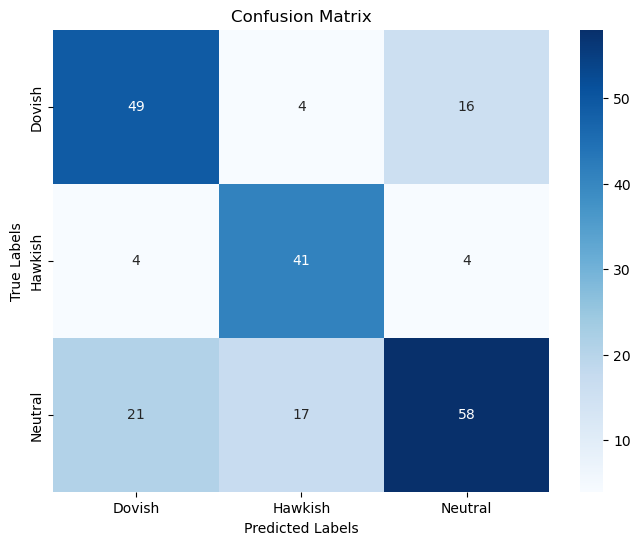

In [27]:
# Load the best model
best_model = AutoModelForSequenceClassification.from_pretrained(best_model_path)

# Create the Trainer with the test set as eval_dataset
trainer = Trainer(
    model=best_model,
    args=training_args,
    eval_dataset=tokenized_test_dataset  # Pass the test set for final evaluation
)

# Perform final evaluation on the test set
test_predictions, test_labels, _ = trainer.predict(tokenized_test_dataset)
test_predictions = np.argmax(test_predictions, axis=1)

# Print classification report to get F1 score, precision, recall, etc.
test_report = classification_report(test_labels, test_predictions, target_names=['Dovish', 'Hawkish', 'Neutral'])
print("Classification Report on Test Dataset:\n", test_report)

# Compute and print confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Dovish', 'Hawkish', 'Neutral'], yticklabels=['Dovish', 'Hawkish', 'Neutral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# # Sample CSV generation for copying the test predictions to txt file and saving locally for report plotting
# csv_content = "Sentence,True Label,Predicted Label\n"  # Header

# for i, (true_label, pred_label) in enumerate(zip(test_labels, test_predictions)):
#     filename = f"test_sample_{i}"  # Example filename placeholder, replace with actual data if available
#     csv_content += f"{filename},{true_label},{pred_label}\n"

# # Print CSV content for copying and saving locally
# print(csv_content)

In [ ]:
# # If no enough space, use this code to delete checkpoint folders except the best combination to release desk space for further task
# import os
# import shutil

# learning_rates = [2e-5, 5e-5, 1e-4]  
# batch_sizes = [4, 8, 16]            
# num_epochs = [3, 5, 10]       

# best_lr = best_result['learning_rate']
# best_batch_size = best_result['batch_size']
# best_epoch = best_result['epochs']

# # base dir
# base_dir = '/home/app/hsq/results_lr{lr}_bs{batch_size}_epochs{epoch}'

# # Delete all checkpoint folders except for the specified best combination
# for lr in learning_rates:
#     for batch_size in batch_sizes:
#         for epoch in num_epochs:
#             # Check if the current combination is not the best one
#             if lr != best_lr or batch_size != best_batch_size or epoch != best_epoch:
#                 print(f"Keeping directory: {base_dir.format(lr=lr, batch_size=batch_size, epoch=epoch)}")
#                 continue
                
#             # Construct the output directory path
#             output_dir = base_dir.format(lr=lr, batch_size=batch_size, epoch=epoch)

#             # Check if the directory exists and delete it if it does
#             if os.path.exists(output_dir):
#                 print(f"Deleting directory: {output_dir}")
#                 shutil.rmtree(output_dir)
#             # else:
#             #     print(f"Directory not found: {output_dir}")

# print("All specified checkpoints have been deleted, except the best combination.")

### Step 2: Inference Using the Fine-Tuned Model

1. **Filtering and Inference on FOMC Meeting Minutes:**
* Tokenize the raw text files into sentences.
* Before running inference, filter the sentences from the FOMC meeting minutes
(January 1996 to September 2024) based on the presence of words from **Panel A1** or **B1** in Table 1 of the paper. Only sentences containing these keywords should be kept for further analysis.
* Once the sentences are filtered, use the fine-tuned model to perform inference on the remaining sentences. Mark each sentence as hawkish, dovish, or neutral.
* Save the predictions to a file, specifying whether each sentence is hawkish, dovish, or neutral.

2. **Construct a Hawkishness Measure:**

* Following the method described in the paper, construct a **document-level hawkishness measure**. For each document (FOMC meeting minute), compute:

$$\text{Hawkishness} = \frac{\# \text{Hawkish sentences} - \# \text{Dovish sentences}}{\# \text{Total filtered sentences}}$$

* Save these results for the next step.

In [28]:
# open meeting_minutes_raw_text_files.zip
with open('meeting_minutes_raw_text_files.zip', 'rb') as f:
    zip_file = zipfile.ZipFile(io.BytesIO(f.read()))

# list all files in the zip
# print("Files in zip:", zip_file.namelist())b

# Read the contents of all .txt files in the zip
def load_text_files_from_zip(zip_file):
    raw_texts = {}
    for filename in zip_file.namelist():
        if filename.endswith('.txt'):
            with zip_file.open(filename) as file:
                content = file.read().decode('utf-8')  # Decoding file content
                raw_texts[filename] = content  # Use file name as key and content as value
    return raw_texts

raw_texts = load_text_files_from_zip(zip_file)

# tokenizer = AutoTokenizer.from_pretrained('roberta-base')

# def tokenize_text(text):
#     return tokenizer.tokenize(text)

# tokenized_texts = {filename: tokenize_text(text) for filename, text in raw_texts.items()}

In [29]:
keywords = [ "inflation expectation", "interest rate", "bank rate", "fund rate", "price", "economic activity", "inflation", "employment"] 

# def a func that use re to seperate sentences
def split_sentences(text):
    # Use regular expressions to split sentences based on '.''?''!', and similar punctuation, while avoiding splits on abbr. and other cases.
    sentence_endings = re.compile(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s')
    sentences = sentence_endings.split(text)
    return [sentence.strip() for sentence in sentences if sentence]  # Remove blank sentences

# def a func that filter sentences with keywords
def filter_sentences(tokenized_sentences, keywords):
    filtered = [sentence for sentence in tokenized_sentences if any(keyword in sentence.lower() for keyword in keywords)]
    return filtered

# filter text
filtered_texts = {}
for filename, text in raw_texts.items():
    sentences = split_sentences(text)
    filtered_sentences = filter_sentences(sentences, keywords)
    if filtered_sentences:
        filtered_texts[filename] = filtered_sentences

In [30]:
# def a func that convert the filtered sentences into a dataset format acceptable to the model
def prepare_dataset(filtered_sentences):
    encodings = tokenizer(filtered_sentences, padding=True, truncation=True, max_length=256)
    return HFDataset.from_dict(encodings)
    
# Inference on each filtered sentence and save the results
inference_results = {}
for filename, sentences in filtered_texts.items():
    dataset = prepare_dataset(sentences)  # Convert sentences to Dataset format
    predictions = trainer.predict(dataset).predictions  # Use .predict for inference
    predicted_labels = predictions.argmax(-1)  # Obtain the category index with the highest probability in the model prediction results
    inference_results[filename] = predicted_labels

# save result to csv
import csv

with open('inference_results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Filename", "Sentence", "Prediction"])  # Headers
    for filename, predictions in inference_results.items():
        for sentence, prediction in zip(filtered_texts[filename], predictions):
            label = ["Dovish", "Hawkish", "Neutral"][prediction]
            writer.writerow([filename, sentence, label])


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# # Print all inference result and save to txt file locally for report plotting
# csv_output = "Filename,Sentence,Prediction\n"  # CSV Header

# # Generate CSV content from inference results (mockup example since actual data is not available)
# for filename, predictions in inference_results.items():
#     for sentence, prediction in zip(filtered_texts[filename], predictions):
#         label = ["Dovish", "Hawkish", "Neutral"][prediction]
#         csv_output += f"{filename},{sentence},{label}\n"

# print(csv_output)

In [31]:
# calculate Hawkishness measure using formula
hawkishness_scores = {}
for filename, predictions in inference_results.items():
    hawkish_count = (predictions == 1).sum()  # 1: Hawkish
    dovish_count = (predictions == 0).sum()   # 0: Dovish
    total_count = len(predictions)
    
    hawkishness = (hawkish_count - dovish_count) / total_count
    hawkishness_scores[filename] = hawkishness

# save Hawkishness score to csv
with open('hawkishness_scores.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Filename", "Hawkishness Score"])  # header
    for filename, score in hawkishness_scores.items():
        writer.writerow([filename, score])

In [32]:
# read csv as pandas df, and format df for step3 comparison
hawkishness_data = pd.read_csv('hawkishness_scores.csv')

hawkishness_data['Date'] = pd.to_datetime(hawkishness_data['Filename'].str.extract(r'(\d{8})\.txt')[0], format='%Y%m%d')
hawkishness_data['Month'] = hawkishness_data['Date'].dt.to_period('M')

In [ ]:
# print(hawkishness_data)

In [ ]:
# # Print all hawkishness_score result and save to txt file locally for report plotting
# csv_content = "Filename,Hawkishness Score,Date,Month\n"  # Header

# # Iterate through the DataFrame and add each row to the CSV content
# for index, row in hawkishness_data.iterrows():
#     csv_content += f"{row['Filename']},{row['Hawkishness Score']},{row['Date']},{row['Month']}\n"

# print(csv_content)

### Step 3: Analysis of CPI, PPI, and Recession
---
**Provide commentary on what you observe in the relationship between monetary policy stance (hawkish/dovish), CPI, PPI, and periods of recession. Do you see any patterns in how the hawkishness measure relates to inflation or economic downturns?**

- **Hawkishness and Inflation Relationship**: 
  - The Fed typically becomes more hawkish as inflation rises - we see the hawkishness measure increasing alongside climbing CPI and PPI, as demonstrated in both the early 2000s and 2021-2022 inflationary periods. Conversely, when inflation metrics decline, the Fed adopts a more dovish stance by lowering interest rates and expanding money supply to support economic growth.

- **Economic Downturns and Dovish Shifts**: 
  - During recessions, there's a clear pattern of the hawkishness measure dropping sharply as the Fed pivots to dovish policies - lowering rates and increasing market liquidity to stimulate economic recovery. This was particularly evident during the 2008 financial crisis and 2020 pandemic recession.

- **Lagged Effects and Policy Impact**: 
  - There appears to be a slight lag between peaks in the hawkishness measure and the subsequent stabilization or decline in inflation (both CPI and PPI). This suggests that the effects of restrictive policy measures on inflation are not immediate and may take several months or quarters to materialize.

In [43]:
# Macro economic indicators from FRED, monthly data
import pandas_datareader as pdr
from datetime import datetime

# Define the start and end dates
start_date = datetime(1996, 1, 1)
end_date = datetime(2024, 10, 31)

# Fetch FRED data using pandas_datareader
cpi = pdr.get_data_fred('CPIAUCSL', start=start_date, end=end_date)
ppi = pdr.get_data_fred('PPIACO', start=start_date, end=end_date)

# Reset index for better handling
cpi.reset_index(inplace=True)
ppi.reset_index(inplace=True)

# Rename columns for clarity
cpi.columns = ['Date', 'CPI']
ppi.columns = ['Date', 'PPI']

# Create Month column
cpi['Month'] = pd.to_datetime(cpi['Date']).dt.to_period('M')
cpi = cpi.drop(['Date'], axis = 1)
ppi['Month'] = pd.to_datetime(ppi['Date']).dt.to_period('M')
ppi = ppi.drop(['Date'], axis = 1)

macro_indicators = pd.merge(cpi, ppi, on="Month", how='left')

In [44]:
# Add USREC data
NBER_df = pdr.get_data_fred('USREC', start=start_date, end=end_date)
NBER_df.reset_index(inplace=True)
NBER_df.columns = ['Date', 'NBER']
NBER_df['Month'] = pd.to_datetime(NBER_df['Date']).dt.to_period('M')
NBER_df = NBER_df[(NBER_df['Month'] >= '1996-01') & (NBER_df['Month'] <= '2024-10')]
NBER_df = NBER_df.drop(['Date'], axis = 1)

macro_indicators = pd.merge(macro_indicators, NBER_df, on="Month", how='left')

**Plot - Annual percentage change of CPI and PPI over time (1996-2024), overlayed with a recession indicator:**

In [45]:
# Calculate the annual percentage change for CPI and PPI
macro_indicators['CPI_pct_change'] = macro_indicators['CPI'].pct_change(periods=12) * 100
macro_indicators['PPI_pct_change'] = macro_indicators['PPI'].pct_change(periods=12) * 100

# Drop any rows with NaN values in percentage change columns
macro_indicators = macro_indicators.dropna(subset=['CPI_pct_change', 'PPI_pct_change'])

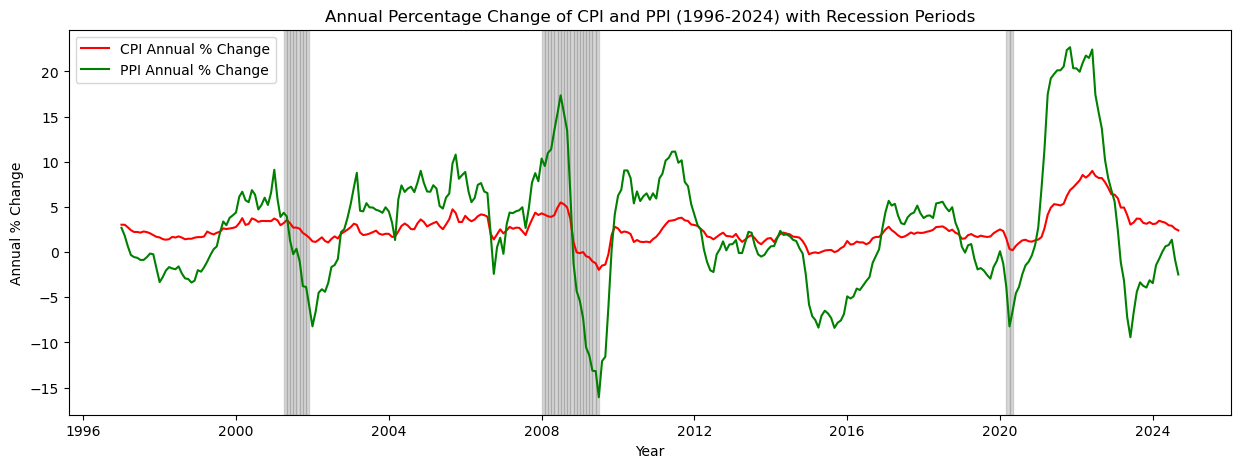

In [46]:
# Plot CPI and PPI annual percentage change with recession periods highlighted
plt.figure(figsize=(15, 5))

# Plot CPI and PPI percentage changes
plt.plot(macro_indicators['Month'].dt.to_timestamp(), macro_indicators['CPI_pct_change'], label='CPI Annual % Change', color='red')
plt.plot(macro_indicators['Month'].dt.to_timestamp(), macro_indicators['PPI_pct_change'], label='PPI Annual % Change', color='green')

# Highlight recession periods using NBER recession indicator
recession_periods = macro_indicators[macro_indicators['NBER'] == 1]
for idx, row in recession_periods.iterrows():
    plt.axvspan(row['Month'].start_time, row['Month'].end_time, color='gray', alpha=0.3)

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Annual % Change')
plt.title('Annual Percentage Change of CPI and PPI (1996-2024) with Recession Periods')
plt.legend(loc='upper left')

# Show the plot
plt.savefig("CPI_PPI_with_Recession_Periods.svg", format="svg")  # Save as SVG
plt.show()

**Plot - Overlay Hawkishness measure with CPI, PPI, and recession indicator:**

In [36]:
macro_with_hawkishness = pd.merge(macro_indicators, hawkishness_data[['Month', 'Hawkishness Score']], on='Month', how='left')

# Sort the dataframe by 'Month' before applying fillna
macro_with_hawkishness = macro_with_hawkishness.sort_values(by='Month')

# Fill missing Hawkishness scores using forward fill
macro_with_hawkishness['Hawkishness Score'].fillna(method='ffill', inplace=True)

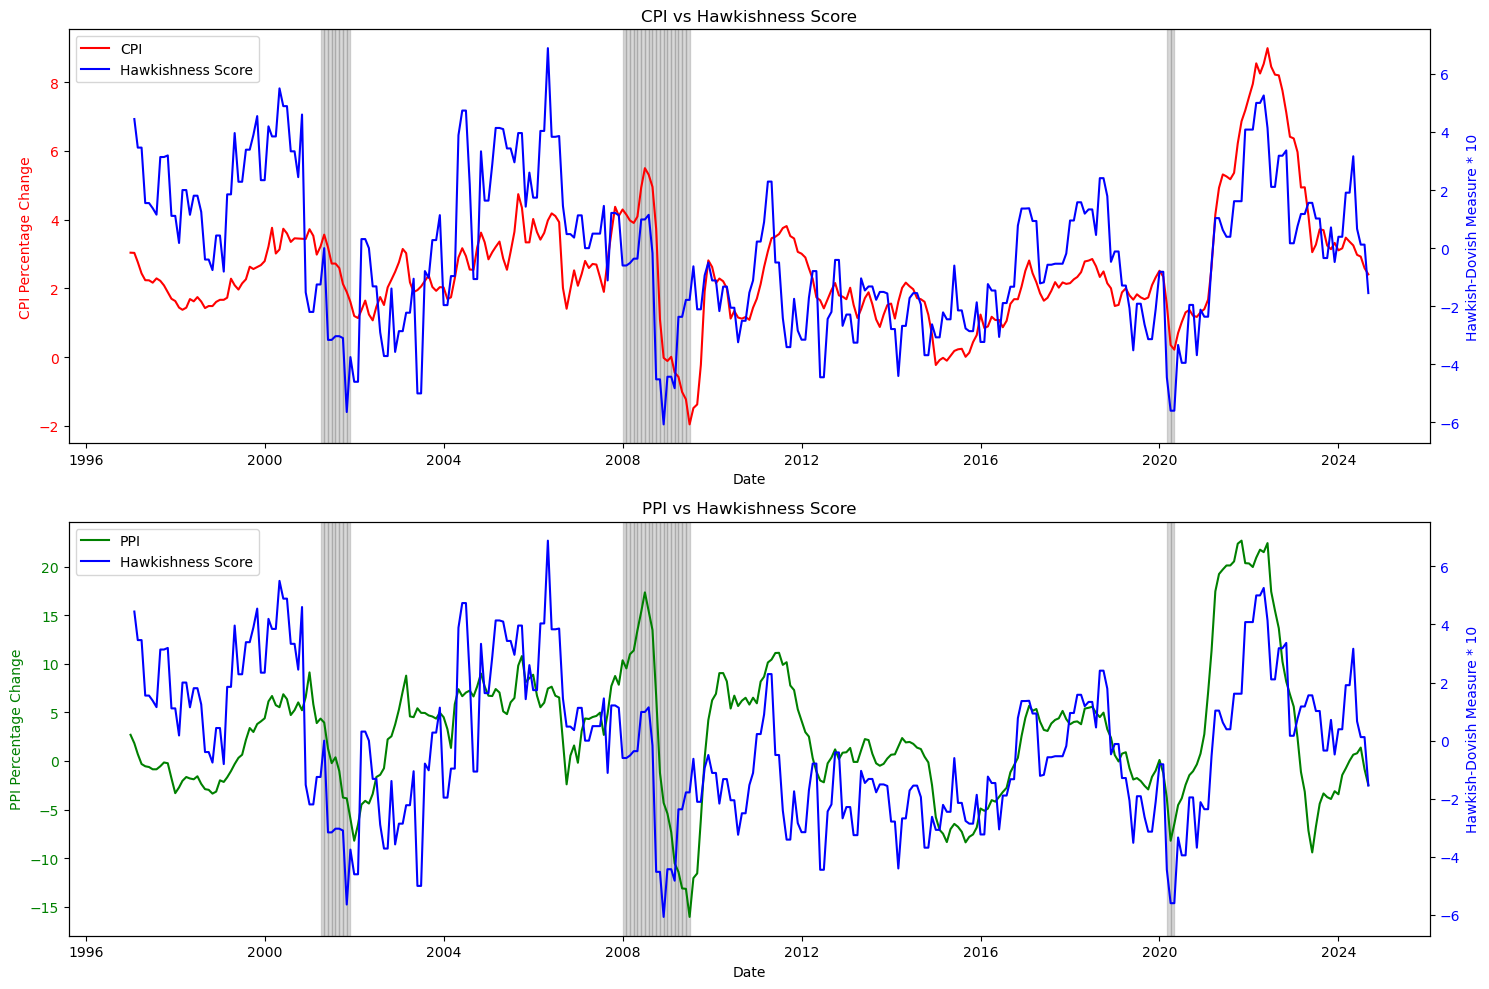

In [39]:
# Set up the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# First subplot: CPI vs Hawkishness
cpi_line, = ax1.plot(macro_with_hawkishness['Month'].dt.to_timestamp(), 
                     macro_with_hawkishness['CPI_pct_change'], label='CPI', color='red')
ax1.set_ylabel('CPI Percentage Change', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xlabel('Date')

# Secondary axis for Hawkishness score
ax1_2 = ax1.twinx()
hawkishness_line1, = ax1_2.plot(macro_with_hawkishness['Month'].dt.to_timestamp(), 
                                macro_with_hawkishness['Hawkishness Score'] * 10, label='Hawkishness Score', color='blue')
ax1_2.set_ylabel('Hawkish-Dovish Measure * 10', color='blue')
ax1_2.tick_params(axis='y', labelcolor='blue')

# Title for the first subplot
ax1.set_title('CPI vs Hawkishness Score')

# Combine legends for both CPI and Hawkishness
lines1 = [cpi_line, hawkishness_line1]
ax1.legend(lines1, [line.get_label() for line in lines1], loc='upper left')

# Second subplot: PPI vs Hawkishness
ppi_line, = ax2.plot(macro_with_hawkishness['Month'].dt.to_timestamp(), 
                     macro_with_hawkishness['PPI_pct_change'], label='PPI', color='green')
ax2.set_ylabel('PPI Percentage Change', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_xlabel('Date')

# Secondary axis for Hawkishness score
ax2_2 = ax2.twinx()
hawkishness_line2, = ax2_2.plot(macro_with_hawkishness['Month'].dt.to_timestamp(), 
                                macro_with_hawkishness['Hawkishness Score'] * 10, label='Hawkishness Score', color='blue')
ax2_2.set_ylabel('Hawkish-Dovish Measure * 10', color='blue')
ax2_2.tick_params(axis='y', labelcolor='blue')

# Title for the second subplot
ax2.set_title('PPI vs Hawkishness Score')

# Combine legends for both PPI and Hawkishness
lines2 = [ppi_line, hawkishness_line2]
ax2.legend(lines2, [line.get_label() for line in lines2], loc='upper left')

# Highlighting recession periods for both plots
recession_periods = macro_with_hawkishness[macro_with_hawkishness['NBER'] == 1]
for idx, row in recession_periods.iterrows():
    ax1.axvspan(row['Month'].start_time, row['Month'].end_time, color='gray', alpha=0.3)
    ax2.axvspan(row['Month'].start_time, row['Month'].end_time, color='gray', alpha=0.3)

# Finalize plot layout
plt.tight_layout()
plt.savefig("CPI_PPI_with_Hawkishness_Score.svg", format="svg")  # Save as SVG
plt.show()